---
## 1. Data Upload
---

### Import libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import sys
from sklearn.metrics import r2_score  # We import the efficiency metric
from scipy.optimize import curve_fit



### Import functions

In [19]:
# 1. Obtenemos la ruta absoluta de la carpeta actual (notebooks)
current_path = os.getcwd()

# 2. Subimos un nivel para llegar a la raíz del proyecto
root_path = os.path.dirname(current_path)

# 3. Agregamos la carpeta 'scripts' al sistema si no está ya presente
scripts_path = os.path.join(root_path, 'scripts')
if scripts_path not in sys.path:
    sys.path.append(scripts_path)

# 4. Ahora ya puedes importar directamente las funciones
from dca_functions import hyperbolic_decline, calculate_eur, detect_multiple_breaks, fit_arps_model
from advanced_models import fit_advanced_model, sepd_decline, power_law_decline

print("¡Importación exitosa!")


¡Importación exitosa!


### Aesthetic configuration

In [3]:
plt.style.use('seaborn-v0_8-whitegrid')

### Load processed dataset

In [4]:
# Load the clean data from the 5 wells
df = pd.read_csv('../data/processed/well_data_cleaned.csv')
df['dateprd'] = pd.to_datetime(df['dateprd'])

# Obtain the list of selected wells
well_names = df['npd_well_bore_name'].unique()
print(f"Wells ready for modeling: {list(well_names)}")

Wells ready for modeling: ['15/9-F-1 C', '15/9-F-11', '15/9-F-12', '15/9-F-14', '15/9-F-15 D']


---
# 2. Modeling
---

### i. `ARPS` Model

The model most commonly used as an initial test for modeling the decline curve of a deposit is the ARPS model, and we will begin by visualizing the results of attempting to model using this tool.

### $$q(t)= \frac{q_i}{(1+bD_it) ^ \frac{1}{b}}$$

In [5]:
results = []

for well in well_names:
    # 1. Filter the well and ensure we only use the decline phase.
    # (We look for the peak production point to begin adjustments from there.)
    df_well = df[df['npd_well_bore_name'] == well].copy()
    peak_date = df_well.loc[df_well['bore_oil_vol'].idxmax(), 'dateprd']
    df_decline = df_well[df_well['dateprd'] >= peak_date].copy()
    
    # Variables X (days since peak) and Y (production)
    x_data = (df_decline['dateprd'] - df_decline['dateprd'].min()).dt.days.values
    y_data = df_decline['bore_oil_vol'].values
    
    try:
        # 2. Arps Curve Fitting
        # p0: initial estimates [Qi, Di, b]
        popt, _ = curve_fit(hyperbolic_decline, x_data, y_data, 
                            p0=[y_data[0], 0.001, 0.5], 
                            bounds=(0, [y_data[0]*1.2, 1, 1]))
        
        qi, di, b = popt
        y_pred = hyperbolic_decline(x_data, *popt)
        
        # 3. Calculate Efficiency (R^2)
        r2 = r2_score(y_data, y_pred)
        
        # 4. Calculate EUR
        eur = calculate_eur(qi, di, b)
        
        results.append({
            'Well_name': well,
            'Qi (bpd)': round(qi, 2),
            'Di (monthly)': round(di, 4),
            'b (coef)': round(b, 4),
            'Efficiency (R2)': round(r2, 4),
            'EUR (MMbbl)': round(eur / 1e6, 3)
        })
    except:
        print(f"The {well} well could not be adjusted")

# Create comparison table
df_results = pd.DataFrame(results)
df_results.sort_values(by='Efficiency (R2)', ascending=False, inplace=True)
df_results

,Well_name,Qi (bpd),Di (monthly),b (coef),Efficiency (R2),EUR (MMbbl)
3,15/9-F-14,3165.72,0.0011,0.0,0.8057,83.275
2,15/9-F-12,5323.07,0.0015,0.0,0.7994,103.607
1,15/9-F-11,1901.26,0.0027,0.0,0.7415,21.098
0,15/9-F-1 C,1244.11,0.0204,1.0,0.5393,5.969
4,15/9-F-15 D,291.27,0.0024,1.0,0.2714,6.607


Note that the calculated `R²` efficiency levels for each well reveal an acceptable model fit only for wells `F-11`, `F-12`, and `F-14`, showing values ​​between `0.74` and `0.81`. This situation can be improved. As for wells `F-1 C` and `F-15 D`, the model fails to accurately simulate their behavior.

When attempting to simulate the decline curve, factors not explicitly expressed in the production data must be considered, such as well stimulation, pump changes, or the opening of a new zone, among others. Therefore, a segmented ARPS model is typically used, with segments defined by the detection of change points—that is, the dates on which a sudden increase in well production is observed.

Consequently, we created a function to detect these change points, using basic parameters that prevent the data from being divided into overly small segments.

In [6]:
multi_audit = []

for well in well_names:
    df_w = df[df['npd_well_bore_name'] == well].copy()
  
    # Detectar todos los quiebres
    breaks = detect_multiple_breaks(df_w, window=30, log_diff_threshold=0.30, min_dist=180)
    
    multi_audit.append({
        'Well_name': well,
        'Num_Breaks': len(breaks),
        'Break_dates': [b.date() for b in breaks],
        'Total_days': len(df_w[df_w['bore_oil_vol'] > 0])
    })

df_multi_tab = pd.DataFrame(multi_audit)
df_multi_tab

,Well_name,Num_Breaks,Break_dates,Total_days
0,15/9-F-1 C,2,"[2014-12-07, 2015-08-21]",430
1,15/9-F-11,0,[],1123
2,15/9-F-12,3,"[2012-08-29, 2014-12-08, 2016-08-26]",2836
3,15/9-F-14,3,"[2008-06-29, 2012-08-28, 2016-07-26]",2723
4,15/9-F-15 D,3,"[2014-12-09, 2015-07-31, 2016-07-20]",767


Information is usually much easier to understand if we can represent it through a graph, so below we show the break points detected for each well.

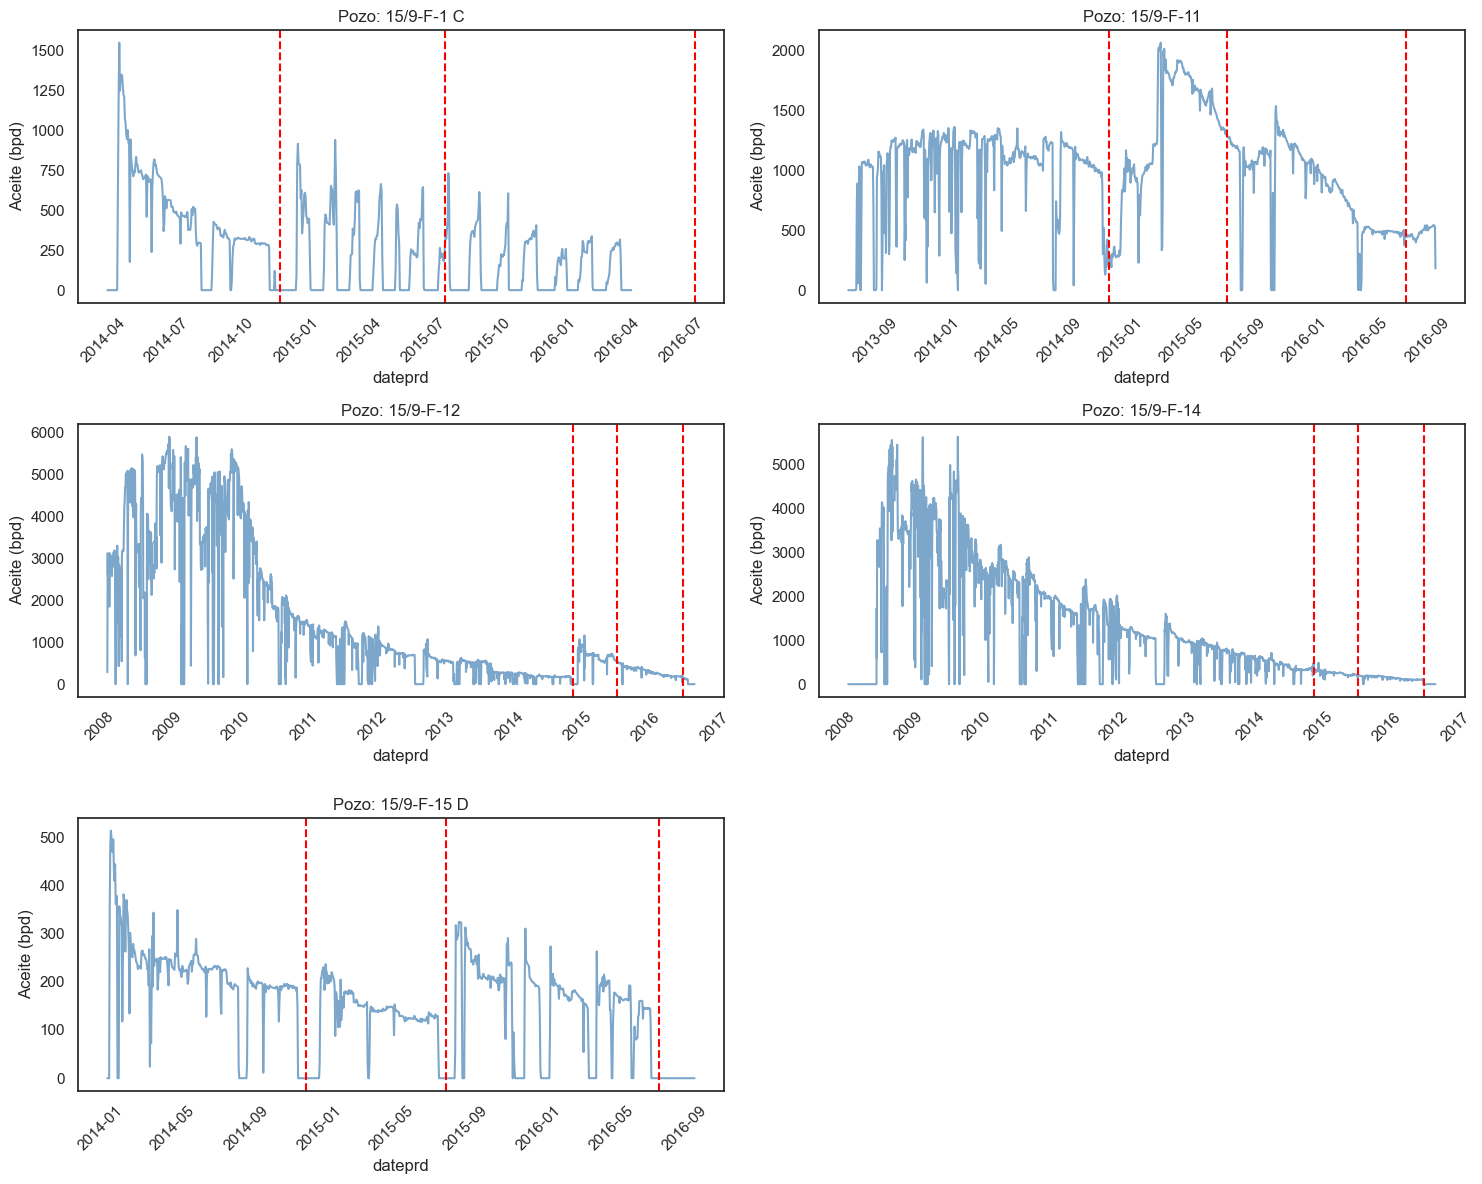

In [7]:
import seaborn as sns

# Configuración del gráfico
sns.set_theme(style="white")
fig, axes = plt.subplots(3, 2, figsize=(15, 12), sharex=False)
axes = axes.flatten()

for i, well in enumerate(well_names):
    df_w = df[df['npd_well_bore_name'] == well].copy()
    
    sns.lineplot(data=df_w, x='dateprd', y='bore_oil_vol', ax=axes[i], color='steelblue', alpha=0.7)
           
    # Dibujar líneas rojas en los quiebres
    for b_date in breaks:
        axes[i].axvline(x=b_date, color='red', linestyle='--', linewidth=1.5, label='Ruptura')
    
    axes[i].set_title(f"Pozo: {well}")
    axes[i].set_ylabel("Aceite (bpd)")
    axes[i].tick_params(axis='x', rotation=45)

# Eliminar el último eje si sobra (tenemos 5 pozos)
if len(well_names) < len(axes):
    fig.delaxes(axes[-1])

plt.tight_layout()
plt.show()

As we can see in the graph, many of these segments define non-modelable sections; therefore, a function is needed that allows us to validate the amount of data in the segment, a situation that will allow us to define whether or not this section is modelable.

In [8]:
def validate_segments(df_well, detected_breaks, min_obs=180):
    """
    Filtra las fechas de quiebre que generan segmentos con muy pocas observaciones.
    min_obs: Mínimo de días con producción > 0 requeridos para considerar un segmento.
    """
    if not detected_breaks:
        return []
    
    # Ordenamos cronológicamente
    detected_breaks = sorted(detected_breaks)
    
    # Definimos los límites temporales (Inicio y Fin de la data)
    start_data = df_well['dateprd'].min()
    end_data = df_well['dateprd'].max()
    all_points = [start_data] + detected_breaks + [end_data]
    
    valid_breaks = []
    
    for i in range(1, len(all_points) - 1):
        # Punto anterior, actual y siguiente
        prev_p = all_points[i-1]
        curr_p = all_points[i]
        next_p = all_points[i+1]
        
        # Contar observaciones reales en el segmento que precede al quiebre
        seg_pre = df_well[(df_well['dateprd'] >= prev_p) & (df_well['dateprd'] < curr_p)]
        obs_pre = len(seg_pre[seg_pre['bore_oil_vol'] > 0])
        
        # Contar observaciones reales en el segmento que sigue al quiebre
        seg_post = df_well[(df_well['dateprd'] >= curr_p) & (df_well['dateprd'] < next_p)]
        obs_post = len(seg_post[seg_post['bore_oil_vol'] > 0])
        
        # Solo aceptamos el quiebre si ambos lados tienen suficiente "historia"
        if obs_pre >= min_obs and obs_post >= min_obs:
            valid_breaks.append(curr_p)
        else:
            # Si el quiebre no es válido, "unimos" los segmentos virtualmente
            # para la siguiente iteración de validación
            all_points.pop(i)
            return validate_segments(df_well, all_points[1:-1], min_obs) # Recursión para re-validar

    return valid_breaks

Now let's calculate the new efficiency values ​​after having sectioned the analysis in the wells that our function detected needed it.

In [9]:
final_results = []

for well in well_names:
    df_w = df[df['npd_well_bore_name'] == well].copy().sort_values('dateprd')
    
    # 1. Detección cruda de quiebres
    raw_breaks = detect_multiple_breaks(df_w, window=30, log_diff_threshold=0.25, min_dist=180)
    
    # 2. SINCERAMIENTO: Validar que cada segmento tenga al menos 180 observaciones
    # Esto elimina los "falsos quiebres" que detectaste visualmente
    clean_breaks = validate_segments(df_w, raw_breaks, min_obs=100)
    
    # 3. Modelado Arps (usando clean_breaks)
    segment_limits = [df_w['dateprd'].min()] + sorted(clean_breaks) + [df_w['dateprd'].max()]
    
    well_eur_total = 0
    well_r2_list = []
    
    # 4. Iterar sobre cada segmento delimitado
    for j in range(len(segment_limits) - 1):
        start_seg = segment_limits[j]
        end_seg = segment_limits[j+1]
        
        # Filtrar data del segmento actual
        mask = (df_w['dateprd'] >= start_seg) & (df_w['dateprd'] <= end_seg)
        df_seg = df_w[mask].copy()
        
        # Solo modelamos si el segmento tiene suficientes datos (evita el error de F-15 D)
        if len(df_seg[df_seg['bore_oil_vol'] > 0]) > 30:
            # Encontrar el pico local del segmento para iniciar Arps correctamente
            local_peak_idx = df_seg['bore_oil_vol'].idxmax()
            df_fit = df_seg.loc[local_peak_idx:].copy()
            
            x = (df_fit['dateprd'] - df_fit['dateprd'].min()).dt.days.values
            y = df_fit['bore_oil_vol'].values
            
            # Ajuste de Arps usando nuestra función de scripts
            params, r2_seg, _ = fit_arps_model(x, y)
            
            if params is not None:
                well_eur_total += calculate_eur(*params)
                well_r2_list.append(r2_seg)
    
    # 5. Consolidar resultados del pozo
    avg_r2 = np.mean(well_r2_list) if well_r2_list else 0
    
    final_results.append({
        'Pozo': well,
        'Num_Segmentos': len(well_r2_list),
        'Eficiencia_R2': round(avg_r2, 4),
        'EUR_Total (Mbbl)': round(well_eur_total / 1000, 2)
    })

# Visualización de la tabla de auditoría final
df_final_results = pd.DataFrame(final_results).sort_values(by='Eficiencia_R2', ascending=False)
df_final_results

,Pozo,Num_Segmentos,Eficiencia_R2,EUR_Total (Mbbl)
1,15/9-F-11,1,0.7416,21099.51
2,15/9-F-12,3,0.6910,118471.11
3,15/9-F-14,2,0.6839,103651.14
4,15/9-F-15 D,3,0.3769,7015.16
0,15/9-F-1 C,3,0.2585,15532.82


The results are not encouraging, the efficiency levels `R²` deteriorate significantly, except for well `F-11` since it did not need segmentation.

Let's go back to our first attempt at modeling using the `ARPS` model, but, as we have indicated, let's try to appreciate it graphically, in order to see that it is adjusting the tool.

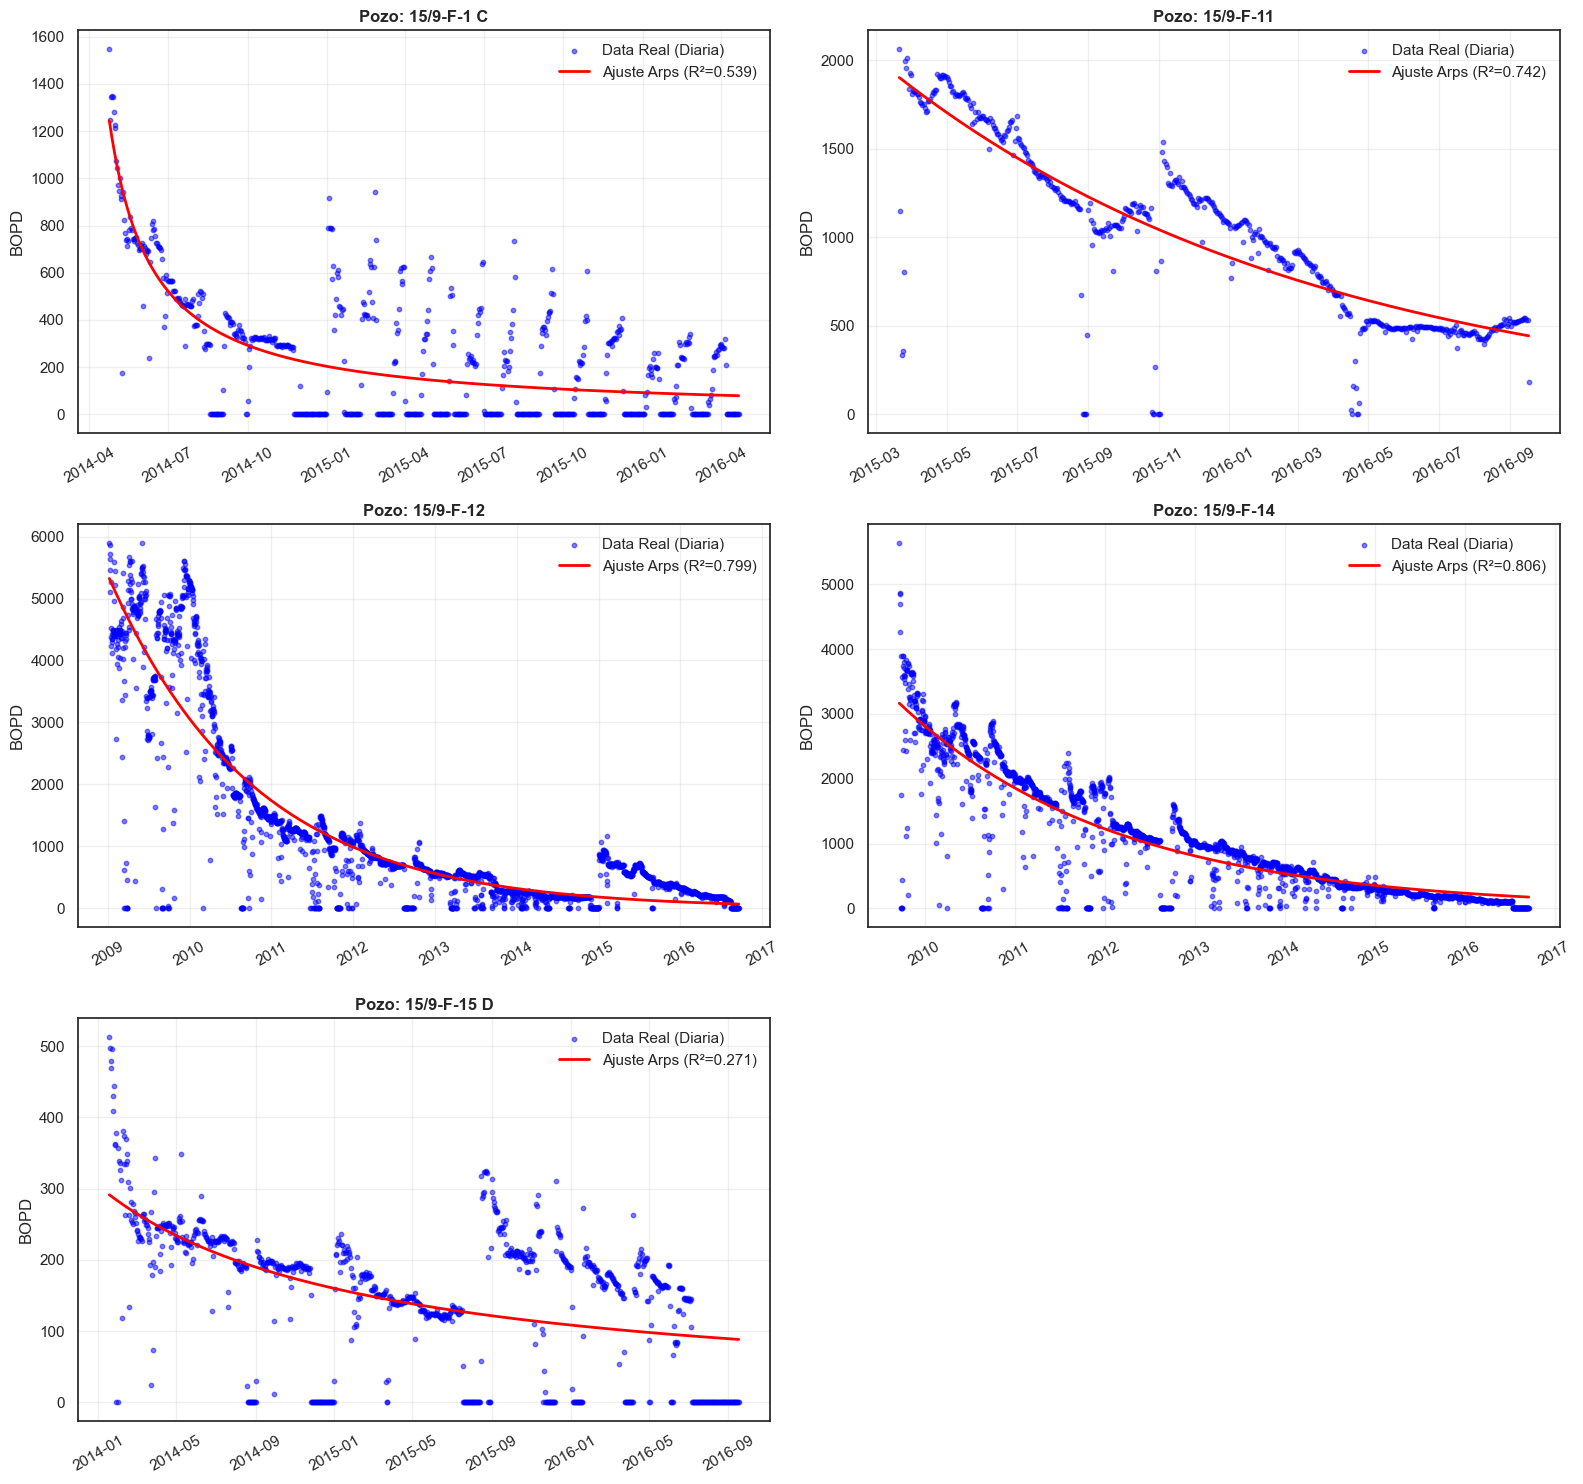

In [31]:
fig, axes = plt.subplots(3, 2, figsize=(16, 15))
axes = axes.flatten()

for i, well in enumerate(well_names):
    # 1. Preparar datos reales
    df_well = df[df['npd_well_bore_name'] == well].copy()
    peak_date = df_well.loc[df_well['bore_oil_vol'].idxmax(), 'dateprd']
    df_decline = df_well[df_well['dateprd'] >= peak_date].copy()
    
    # Variables X (days since peak) and Y (production)
    x_data = (df_decline['dateprd'] - df_decline['dateprd'].min()).dt.days.values
    y_data = df_decline['bore_oil_vol'].values
    
    try:
        # 2. Arps Curve Fitting
        # p0: initial estimates [Qi, Di, b]
        popt, _ = curve_fit(hyperbolic_decline, x_data, y_data, 
                            p0=[y_data[0], 0.001, 0.5], 
                            bounds=(0, [y_data[0]*1.2, 1, 1]))
        
        qi, di, b = popt
        y_pred = hyperbolic_decline(x_data, *popt)
        
        # 3. Calculate Efficiency (R^2)
        r2 = r2_score(y_data, y_pred)
        
        # 4. Calculate EUR
        eur = calculate_eur(qi, di, b)
    except:
        print(f"The {well} well could not be adjusted")
    
    # 3. Graficar
    axes[i].scatter(df_decline['dateprd'], y_data, color='blue', s=10, alpha=0.5, label='Data Real (Diaria)')
    if y_pred is not None:
        axes[i].plot(df_decline['dateprd'], y_pred, color='red', lw=2, label=f'Ajuste Arps (R²={r2:.3f})')
    else:
        # Si falla el ajuste automático, intentamos mostrar la tendencia suavizada 
        # para no dejar el gráfico vacío mientras depuramos
        y_smooth = df_decline['bore_oil_vol'].rolling(window=30).mean()
        axes[i].plot(df_decline['dateprd'], y_smooth, color='orange', linestyle='--', label='Tendencia (Media Móvil)')
    
    axes[i].set_title(f"Pozo: {well}", fontsize=12, fontweight='bold')
    axes[i].set_ylabel("BOPD")
    axes[i].legend()
    axes[i].grid(True, alpha=0.3)
    plt.setp(axes[i].get_xticklabels(), rotation=30)

# Limpieza de ejes vacíos
if len(well_names) < len(axes):
    for j in range(len(well_names), len(axes)):
        fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

### ii. `Power-Law Loss-Ratio` Model.

Among the various models used for analyzing reservoir decline curves, we find another possibility known as the `Power-Law` model. This model bridges the gap between `ARPS` and advanced models. It is excellent for wells that decline very rapidly initially but maintain a long production tail.

The expression that represents it is:

## $$q = \^q_i . t^{-n}$$

In [ ]:
pwr_law_results = []

for well in well_names:
    df_w = df[df['npd_well_bore_name'] == well].copy().sort_values('dateprd')
    
     # Definición de X e Y
    x = (df_w['dateprd'] - df_w['dateprd'].min()).dt.days.values
    y = df_w['bore_oil_vol'].values
    
   
    # 3. Ajuste Ley de Potencia
    _, r2_power, _ = fit_advanced_model('power_law', x, y)
    
    
    
    pwr_law_results.append({
        'Pozo': well,
        'R2_PowerLaw': -round(r2_power, 4)
    })

df_pwr_law = pd.DataFrame(pwr_law_results)

In [18]:
df_pwr_law

,Pozo,R2_PowerLaw
0,15/9-F-1 C,0.0000
1,15/9-F-11,0.0000
2,15/9-F-12,0.4154
3,15/9-F-14,0.0000
4,15/9-F-15 D,0.0000


In [22]:
final_results = []

for well in well_names:
    df_w = df[df['npd_well_bore_name'] == well].copy().sort_values('dateprd')
    
    # Usamos suavizado exponencial porque Arps no captura su realidad
    y_data = df_w['bore_oil_vol'].values
    # Evaluamos el R2 del suavizado sobre la historia para comparar
    y_fit = df_w['bore_oil_vol'].ewm(span=90).mean()
    r2_final = r2_score(y_data, y_fit)
    
    tipo = "Suavizado Exponencial (Data-Driven)"

    final_results.append({
        'Pozo': well,
        'Método': tipo,
        'Eficiencia_R2': round(r2_final, 4),
        'Nota': "Basado en Física" if "Arps" in tipo else "Basado en Tendencia"
    })

df_comparativo = pd.DataFrame(final_results)
df_comparativo

,Pozo,Método,Eficiencia_R2,Nota
0,15/9-F-1 C,Suavizado Exponencial (Data-Driven),0.3907,Basado en Tendencia
1,15/9-F-11,Suavizado Exponencial (Data-Driven),0.5009,Basado en Tendencia
2,15/9-F-12,Suavizado Exponencial (Data-Driven),0.8526,Basado en Tendencia
3,15/9-F-14,Suavizado Exponencial (Data-Driven),0.7587,Basado en Tendencia
4,15/9-F-15 D,Suavizado Exponencial (Data-Driven),0.3982,Basado en Tendencia
